In [ ]:
'''
Implement anomaly detection for given credit card dataset using Autoencoder and 
build the model by using the following steps: 
a. Import required libraries 
b. Upload / access the dataset 
c. Encoder converts it into latent representation 
d. Decoder networks convert it back to the original input 
e. Compile the models with Optimizer, Loss, and Evaluation Metrics
'''

In [17]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    precision_recall_fscore_support,
    confusion_matrix,
    roc_auc_score,
    roc_curve
)

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

In [18]:
# Reproducitibility
tf.keras.utils.set_random_seed(42)
np.random.seed(42)

In [19]:
# Load dataset
df = pd.read_csv('creditcard.csv')

display(df.head())
print(df.shape, df.columns.tolist())

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


(284807, 31) ['Time', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10', 'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20', 'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'Amount', 'Class']


In [20]:
# Prepare data (normal vs fraud) + scale
# Training autoencoder only on normal transactions

# Separate features (X) and label (y)
assert "Class" in df.columns, "Expected a 'Class' column with 0 (normal) and 1 (fraud)."
X = df.drop(columns=["Class"]).astype("float32").values
y = df["Class"].astype("float32").values

# Split a small "test-like" holdout
X_train_all, X_test_all, y_train_all, y_test_all = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

# Keep only NORMALS for training and validation
X_train_norm = X_train_all[y_train_all == 0]

# Train/Validation split only on NORMAL data
Xn_train, Xn_val = train_test_split(X_train_norm, test_size=0.2, random_state=42)

# Scale using statistics from NORMAL-TRAIN only
scaler = StandardScaler().fit(Xn_train)
Xn_train_s = scaler.transform(Xn_train)
Xn_val_s = scaler.transform(Xn_val)

# Build an evaluation set from the test split (contains both normal and fraud)
X_test_s = scaler.transform(X_test_all)
y_test = y_test_all.copy()

print("Shapes: ",
     "\nXn_train_s: ", Xn_train_s.shape,
     "\nXn_val_s: ", Xn_val_s.shape,
     "\nX_test_s: ", X_test_s.shape,
     "\ny_test: ", y_test.shape)

Shapes:  
Xn_train_s:  (181960, 30) 
Xn_val_s:  (45491, 30) 
X_test_s:  (56962, 30) 
y_test:  (56962,)


In [22]:
# Encoder -> latent representation
# Decoder -> reconstruct original input

input_dim = Xn_train_s.shape[1]
latent_dim = 16

inputs = keras.Input(shape=(input_dim,), name="input_features")

# Encoder
x = layers.Dense(64, activation="relu")(inputs)
x = layers.Dense(32, activation="relu")(x)
latent = layers.Dense(latent_dim, activation="relu", name="latent")(x)

# Decoder
x = layers.Dense(32, activation="relu")(latent)
x = layers.Dense(64, activation="relu")(x)
outputs = layers.Dense(input_dim, activation=None, name="reconstruction")(x)

autoencoder = keras.Model(inputs, outputs, name="creditcard_autoencoder")
autoencoder.summary()

Model: "creditcard_autoencoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_features (InputLayer)          │ (None, 30)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_10 (Dense)                     │ (None, 64)                  │           1,984 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_11 (Dense)                     │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ latent (Dense)                       │ (None, 16)                  │             528 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_12 (Dense)                     │ (None, 32)                  │             544 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_13 (Dense)                     │ (None, 64)                  │           2,112 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ reconstruction (Dense)               │ (None, 30)                  │           1,950 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 9,198 (35.93 KB)

 Trainable params: 9,198 (35.93 KB)

 Non-trainable params: 0 (0.00 B)

In [23]:
# Compile the model + train
autoencoder.compile(
    optimizer=keras.optimizers.Adam(learning_rate=1e-3),
    loss="mse",
    metrics=["mse"]
)

history = autoencoder.fit(
    Xn_train_s, Xn_train_s,   # input = target
    validation_data=(Xn_val_s, Xn_val_s),
    epochs=20,
    batch_size=256,
    shuffle=True,
    verbose=2
)

Epoch 1/20
711/711 - 3s - 5ms/step - loss: 0.4700 - mse: 0.4700 - val_loss: 0.2653 - val_mse: 0.2653
Epoch 2/20
711/711 - 2s - 2ms/step - loss: 0.2189 - mse: 0.2189 - val_loss: 0.1788 - val_mse: 0.1788
Epoch 3/20
711/711 - 2s - 2ms/step - loss: 0.1618 - mse: 0.1618 - val_loss: 0.1433 - val_mse: 0.1433
Epoch 4/20
711/711 - 2s - 2ms/step - loss: 0.1351 - mse: 0.1351 - val_loss: 0.1246 - val_mse: 0.1246
Epoch 5/20
711/711 - 2s - 3ms/step - loss: 0.1189 - mse: 0.1189 - val_loss: 0.1118 - val_mse: 0.1118
Epoch 6/20
711/711 - 2s - 2ms/step - loss: 0.1066 - mse: 0.1066 - val_loss: 0.1018 - val_mse: 0.1018
Epoch 7/20
711/711 - 2s - 2ms/step - loss: 0.0969 - mse: 0.0969 - val_loss: 0.0930 - val_mse: 0.0930
Epoch 8/20
711/711 - 2s - 2ms/step - loss: 0.0897 - mse: 0.0897 - val_loss: 0.0863 - val_mse: 0.0863
Epoch 9/20
711/711 - 2s - 2ms/step - loss: 0.0847 - mse: 0.0847 - val_loss: 0.0818 - val_mse: 0.0818
Epoch 10/20
711/711 - 2s - 2ms/step - loss: 0.0799 - mse: 0.0799 - val_loss: 0.0781 - val_m

In [30]:
# Turn reconstruction error into anomaly detection
# Compute per-sample MSE reconstruction error.
# Set a threshold from normal validation errors

def recon_error(model, data):
    recon = model.predict(data, verbose=0)
    return np.mean((data - recon) ** 2, axis=1)

# Errors for normal validation (to chose threshold) and test set (to eval)
err_val_norm = recon_error(autoencoder, Xn_val_s)
err_test = recon_error(autoencoder, X_test_s)

# Data driver threshold from normla validation erros
threshold = np.percentile(err_val_norm, 95)
print(f"Chosen threshold (95th percentile of normal val errors: {threshold:.6f}")

# Predict anomalies on test set 
y_pred = (err_test > threshold).astype(int)

# Ground truth
y_true = y_test

# Report metrics better suited for imbalanced problems
prec, rec, f1, _ = precision_recall_fscore_support(y_true, y_pred, average="binary", zero_division=0)
auc = roc_auc_score(y_true, err_test)
cm = confusion_matrix(y_true, y_pred)

print(f"Precision: {prec:.4f} Recall: {rec:.4f} F1: {f1:.4f} ROC-AUC: {auc:.4f}")
print("Confusion Matrix: \n", cm)

Chosen threshold (95th percentile of normal val errors: 0.233699
Precision: 0.0284 Recall: 0.8776 F1: 0.0551 ROC-AUC: 0.9575
Confusion Matrix: 
 [[53924  2940]
 [   12    86]]


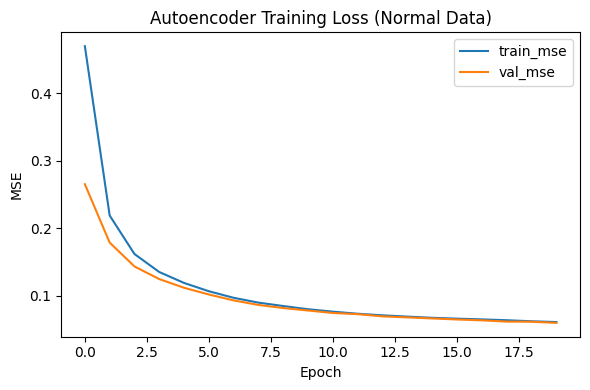

In [31]:
# Training curves (MSE reconstruction loss)
plt.figure(figsize=(6,4))
plt.plot(history.history["loss"], label="train_mse")
plt.plot(history.history["val_loss"], label="val_mse")
plt.xlabel("Epoch")
plt.ylabel("MSE")
plt.title("Autoencoder Training Loss (Normal Data)")
plt.legend()
plt.tight_layout()
plt.show()

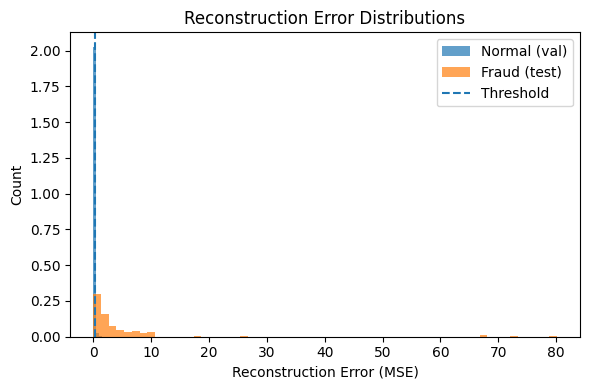

In [37]:
# Error distributions (normal val vs. fraud in test) + threshold line
err_test_norm = err_test[y_true == 0]
err_test_frd = err_test[y_true == 1]

plt.figure(figsize=(6,4))
plt.hist(err_val_norm, bins=60, alpha=0.7, density=True, label="Normal (val)")
plt.hist(err_test_frd, bins=60, alpha=0.7, density=True, label="Fraud (test)")
plt.axvline(threshold, linestyle="--", label="Threshold")
plt.xlabel("Reconstruction Error (MSE)")
plt.ylabel("Count")
plt.title("Reconstruction Error Distributions")
plt.legend()
plt.tight_layout()
plt.show()